In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pytesseract
import tensorflow as tf
import re

print(tf.__version__)

2.1.0


In [2]:
# 그래프 정의
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
with tf.compat.v1.gfile.GFile("ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb","rb") as f:
    graph = tf.compat.v1.GraphDef()
    graph.ParseFromString(f.read())

In [3]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt
# 라벨 맵 불러오기 방법 1
with open("ssd_mobilenet_v1_coco_2018_01_28/mscoco_label_map.pbtxt","rt") as f:
    pb_classes = f.read().rstrip('\n').split('\n')
    
    classes_label = dict()
    for i in range(0, len(pb_classes), 5):
        pb_classId = int(re.findall(r"\d+", pb_classes[i+2])[0])
        pattern = r"display_name: \"(.*?)\""
        pb_text = re.search(pattern, pb_classes[i+3])
        classes_label[pb_classId] = pb_text.group(1)

In [4]:
# 라벨 맵 불러오기 방법 2
# https://developers.google.com/protocol-buffers/docs/downloads 에서 다운받아 proto 파일들을 컴파일 해야 된다.
# https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_complete_label_map.pbtxt
# https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py
from object_detection.utils.label_map_util import get_label_map_dict

tf.gfile = tf.io.gfile
get_label_map_dict.tf = tf.compat.v1

label_map = get_label_map_dict("ssd_mobilenet_v1_coco_2018_01_28/mscoco_complete_label_map.pbtxt", True)
label = dict()
for item in label_map.items():
    label[item[1]] = item[0]

In [5]:
tf = tf.compat.v1

In [6]:
# 세션 생성
with tf.Session() as sess:
    tf.import_graph_def(graph, name='')
    
    # 추론 이미지 생성
    capture = cv2.VideoCapture("files/bird.mp4") # https://www.youtube.com/watch?v=XdlIbNrki5o
    # 이전 프레임, 다음 프레임 생성
    ret, prev_frame = capture.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask = None, maxCorners = 1000, qualityLevel = 0.1,
                                      minDistance = 5, blockSize = 9)
    
    while True:
        ret, next_frame = capture.read()
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        frame = next_frame.copy()
        
        if (capture.get(cv2.CAP_PROP_POS_FRAMES) == capture.get(cv2.CAP_PROP_FRAME_COUNT)):
            break
            
        input_img = cv2.resize(frame, (300,300))
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        
        # 그래프 연산 수행
        num_detections, scores, classes, boxes = sess.run(
            fetches=[sess.graph.get_tensor_by_name("num_detections:0"),
                   sess.graph.get_tensor_by_name("detection_scores:0"),
                   sess.graph.get_tensor_by_name("detection_classes:0"),
                   sess.graph.get_tensor_by_name("detection_boxes:0")],
        feed_dict={"image_tensor:0": input_img.reshape(1, input_img.shape[0], input_img.shape[1],
                                                       input_img.shape[2])}
        )
        
        # 추론 결과 표시
        rows, cols, _ = frame.shape
        for i in range(int(num_detections[0])):
            class_id = int(classes[0][i])
            score = scores[0][i]
            box = boxes[0][i]
            
            if score > 0.7:
                x1 = int(box[1] * cols)
                y1 = int(box[0] * rows)
                x2 = int(box[3] * cols)
                y2 = int(box[2] * rows)
                
                # 객체의 움직임 경로 표시
                flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, flow=None, pyr_scale=0.5,
                                                   levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.1,
                                                   flags = cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

                # 객체의 움직임 표현
                magnitude, angle = cv2.cartToPolar(flow[:,:,0], flow[:,:,1], angleInDegrees=True)
                magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
                angle = angle / 2
                
#                 hsv = np.zeros_like(next_frame)
#                 hsv[:,:,0] = angle
#                 hsv[:,:,1] = magnitude
#                 hsv[:,:,2] = 255
#                 frame = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
                
                for i in range(x1, x2, 15):
                    for j in range(y1, y2, 15):
                        x = int(flow[j, i, 0])
                        y = int(flow[j, i, 1])

                        cv2.circle(frame, (i, j), 1, (0, 0, 255), 1)
                        cv2.line(frame, (i, j), (i + x, j + y), (0, 255, 255), 1)
                        cv2.circle(frame, (i + x, j + y), 1, (0, 255, 255), 1)

                cv2.putText(frame, label[class_id] + ":" + str(score), (x1, y1 - 5), cv2.FONT_HERSHEY_COMPLEX,
                            1.5, (0, 0, 255), 1)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 5)

                
        prev_gray = next_gray.copy()
        cv2.imshow("Object Detections", frame)
        if cv2.waitKey(33) == ord('q'): 
            cv2.destroyAllWindows()
            break

In [10]:
# 피라미드 루카스 카나데 광학 흐름 검출
# 세션 생성
with tf.Session() as sess:
    tf.import_graph_def(graph, name='')
    
    # 추론 이미지 생성
    capture = cv2.VideoCapture("files/bird.mp4") # https://www.youtube.com/watch?v=XdlIbNrki5o
    # 이전 프레임, 다음 프레임 생성
    ret, prev_frame = capture.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask = None, maxCorners = 1000, qualityLevel = 0.1,
                                      minDistance = 5, blockSize = 9)
    
    while True:
        ret, next_frame = capture.read()
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        frame = next_frame.copy()
        
        if (capture.get(cv2.CAP_PROP_POS_FRAMES) == capture.get(cv2.CAP_PROP_FRAME_COUNT)):
            break
            
        input_img = cv2.resize(frame, (300,300))
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        
        # 그래프 연산 수행
        num_detections, scores, classes, boxes = sess.run(
            fetches=[sess.graph.get_tensor_by_name("num_detections:0"),
                   sess.graph.get_tensor_by_name("detection_scores:0"),
                   sess.graph.get_tensor_by_name("detection_classes:0"),
                   sess.graph.get_tensor_by_name("detection_boxes:0")],
        feed_dict={"image_tensor:0": input_img.reshape(1, input_img.shape[0], input_img.shape[1],
                                                       input_img.shape[2])}
        )
        
        # 추론 결과 표시
        rows, cols, _ = frame.shape
        for i in range(int(num_detections[0])):
            class_id = int(classes[0][i])
            score = scores[0][i]
            box = boxes[0][i]
            
            if score > 0.7:
                x1 = int(box[1] * cols)
                y1 = int(box[0] * rows)
                x2 = int(box[3] * cols)
                y2 = int(box[2] * rows)

        
        # 피라미드 루카스 카나데 광학 흐름 검출
        if len(prev_pts) > 0:
            next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_pts, None)
            
            for i, (prev_pt, next_pt) in enumerate(zip(prev_pts, next_pts)):
                xp, yp = prev_pt.ravel()
                xn, yn = next_pt.ravel()
                
                # 우수한 광학 흐름 검출
                dist = int(math.sqrt((xp - xn) * (xp - xn) + (yp - yn) * (yp - yn)))
                if err[i] > 100 or dist > 100 or dist < 5: continue
                if x1 < xp < x2 and y1 < yp < y2:
                    cv2.line(frame, (xp, yp), (xn, yn), (255, 255, 0), 2)
                    cv2.circle(frame, (xn, yn), 3, (0, 0, 255), -1)
                    
        if capture.get(cv2.CAP_PROP_POS_FRAMES) % 10 == 0:
            prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, qualityLevel=0.1,
                                              minDistance=5, blockSize=9)

        
        prev_gray = next_gray.copy()
        cv2.imshow("Object Detections", frame)
        if cv2.waitKey(33) == ord('q'): 
            cv2.destroyAllWindows()
            break

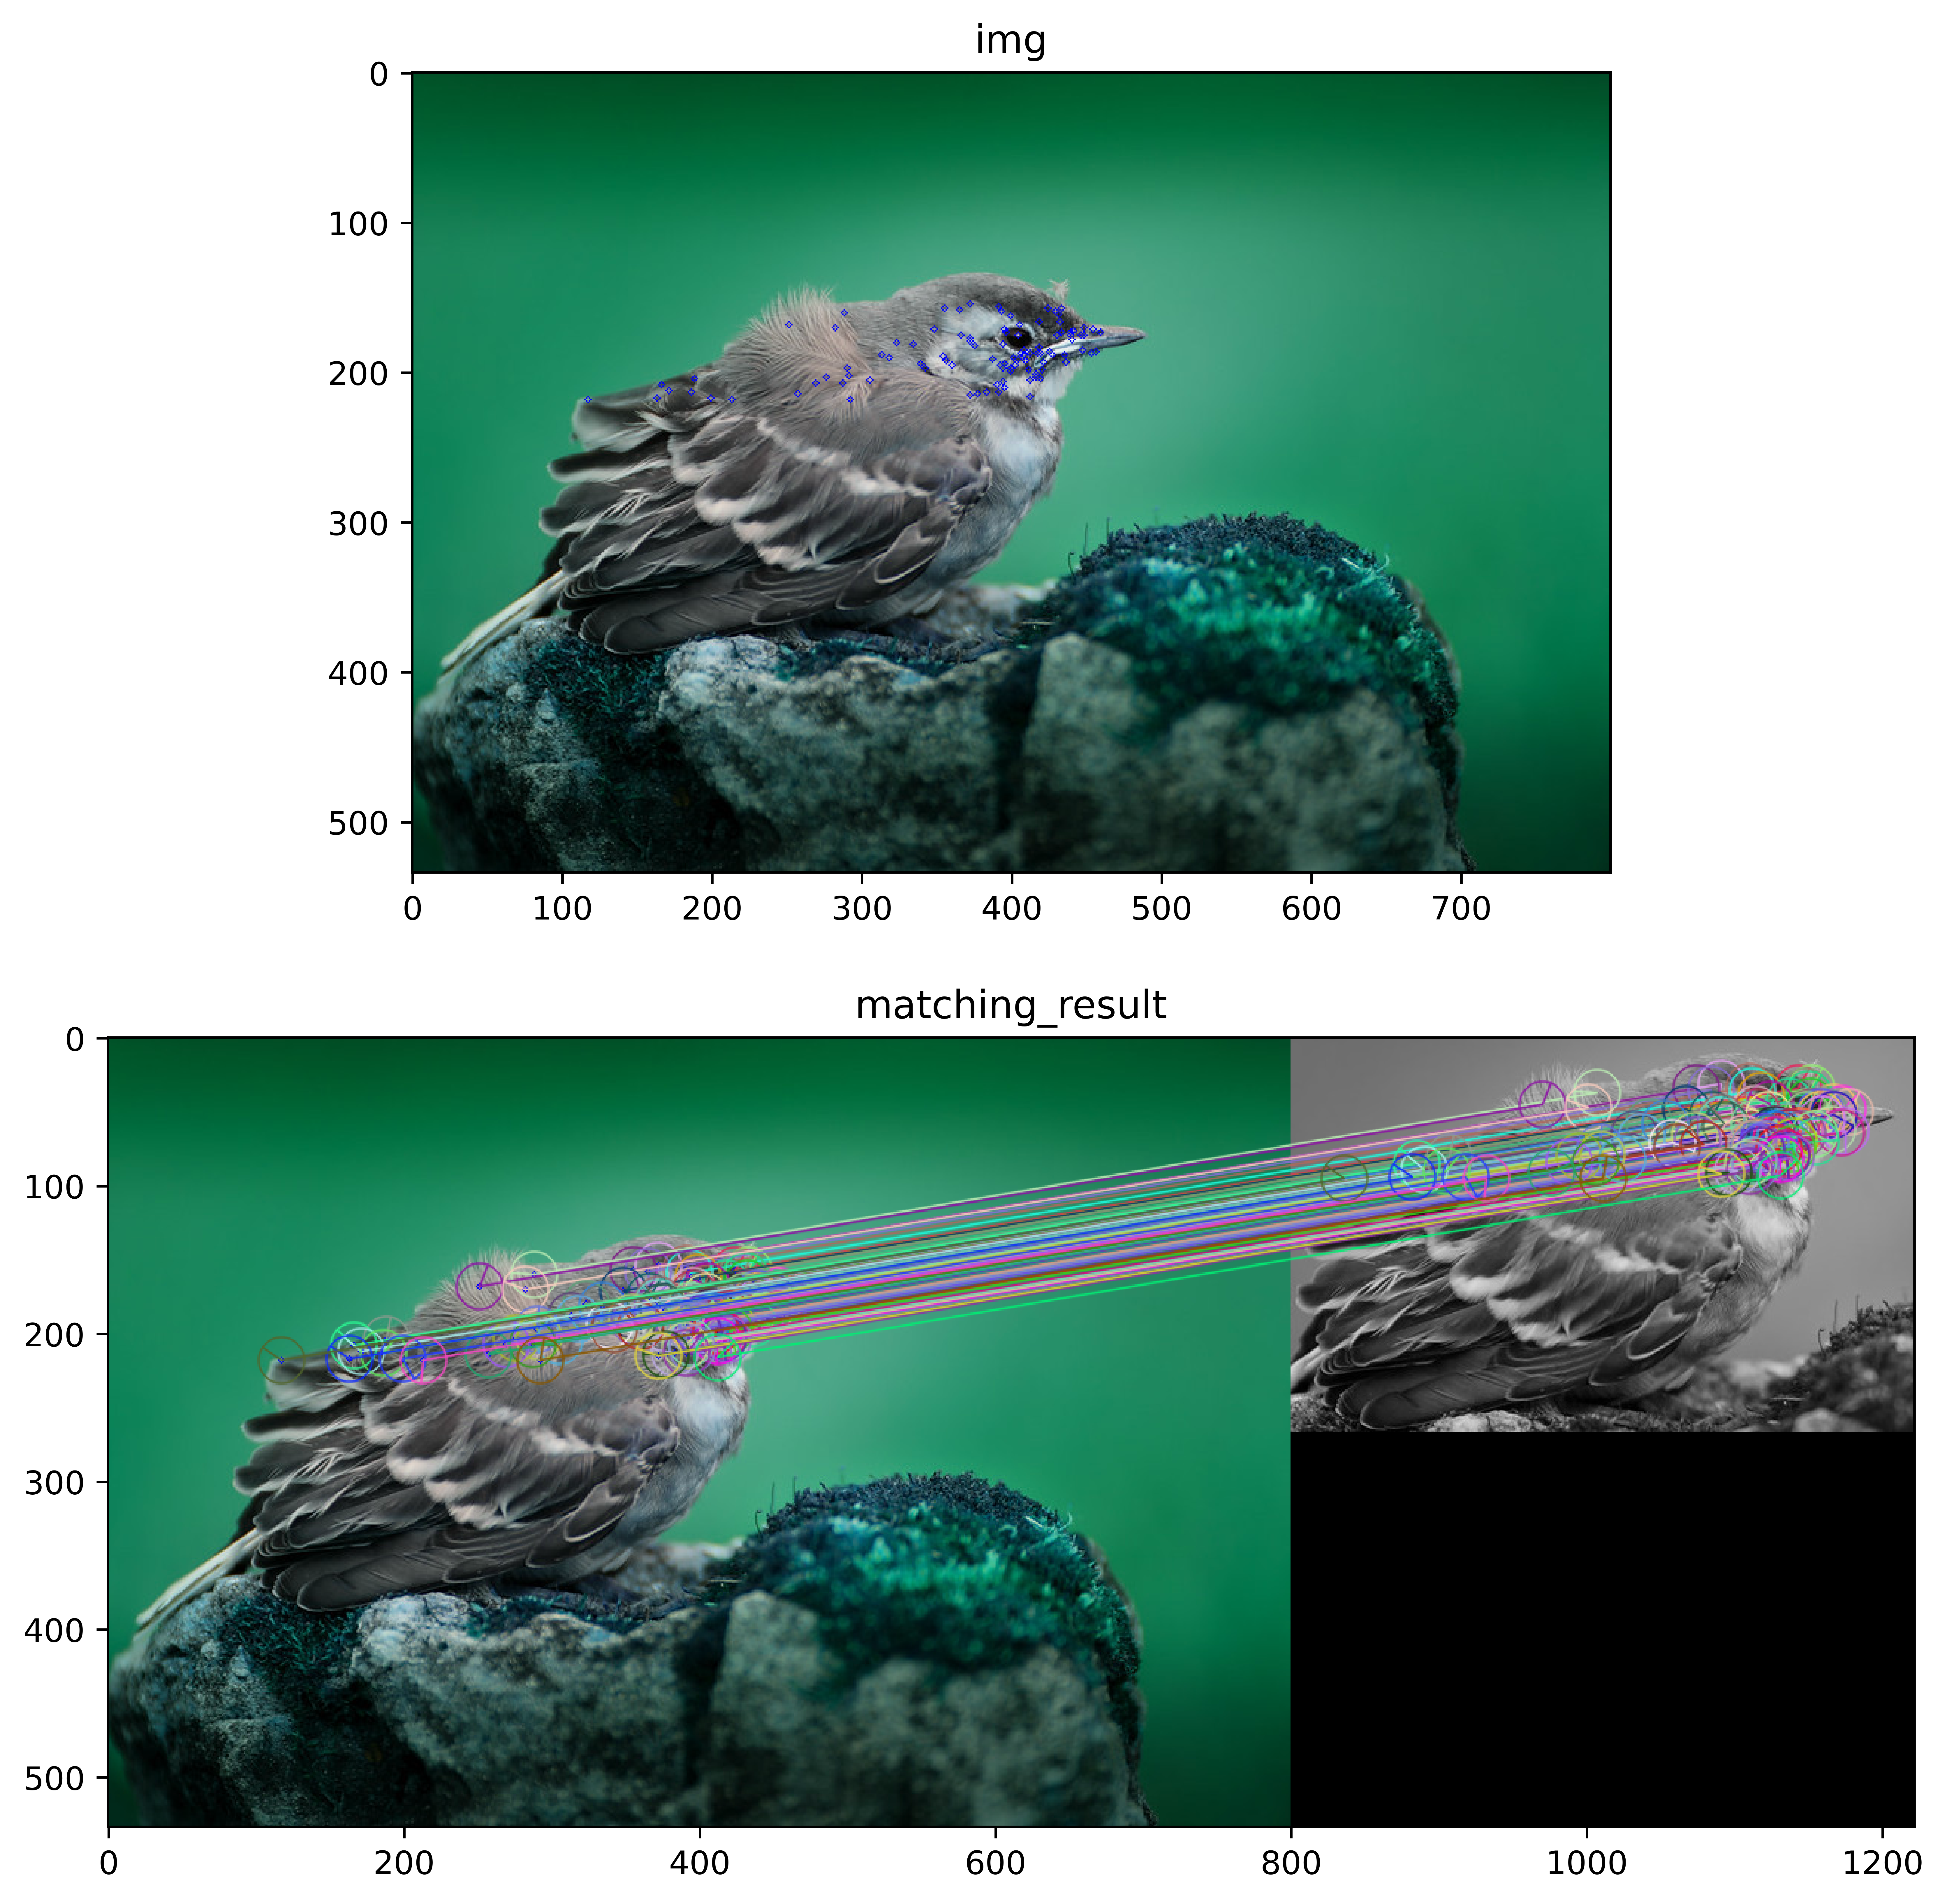

In [7]:
# openCV 만을 이용한 객체 인식
img = cv2.imread("files/bird.jpg")
img_object = cv2.imread("files/bird_object.jpg", cv2.IMREAD_GRAYSCALE)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(nfeatures=40000)
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(img_object, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

count = 100
for i in matches[:count]:
    idx = i.queryIdx
    x1, y1 = kp1[idx].pt
    cv2.circle(img, (int(x1), int(y1)), 2, (0, 0, 255), 1)
    
flag = (cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS |
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
matching_result = cv2.drawMatches(img, kp1, img_object, kp2, matches[:count], None, flags=flag)

fig = plt.figure(num=None, figsize=(10, 10), dpi=800, facecolor='w', edgecolor='k')
rows = 2
cols = 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img)
ax1.set_title('img')
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(matching_result)
ax2.set_title('matching_result')
 
plt.show()